In [2]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e3/f8/9246d3c7e185a29d7359d8b12b3d70bf2c3150ecf1427ec1382290e71a56/tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/8f/aa/ba0014cc4659328dc818a28827be78e6d97312ab0cb98105a770924dc11e/absl_py-2.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/ee/1b/00a78aa2e8fbd63f9af08c9c19e6deb3d5d66b4dda677a0f61654680ee89/flatbuffers-25.9.23-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/a3/61/8001b38461d751c


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2B0

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set a consistent random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Helper function to plot t-SNE
def plot_tsne(tsne_results, labels, title):
    """Plots t-SNE results with colored labels."""
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, 
                          cmap='tab10', alpha=0.7, s=10)
    plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10)), 
               title="Digits")
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

def report_metrics(y_true, y_pred, model_name):
    """Prints accuracy, F1-score, and plots a confusion matrix."""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n--- Metrics for {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return acc, f1


Training Logistic Regression (Saga, faster tolerance)...
Logistic Regression trained in 772.61s
Saga stopped after 209 iterations.

--- Metrics for Logistic Regression (Saga, tol=1e-3) ---
Accuracy: 0.9257
F1-Score (Weighted): 0.9255


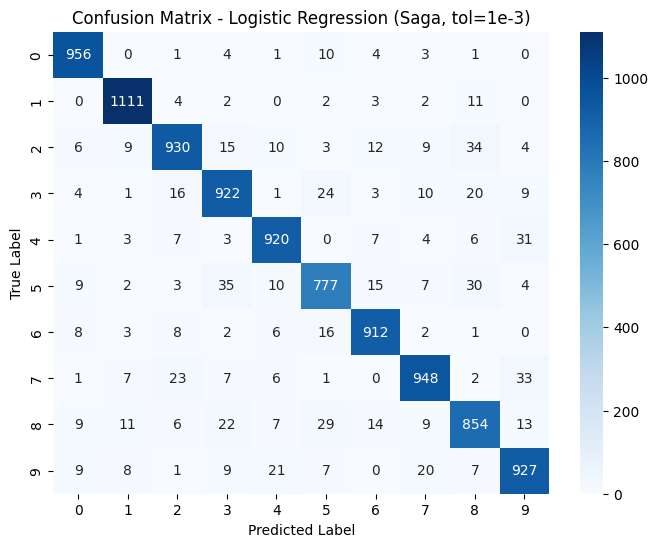


Training Random Forest...

--- Metrics for Random Forest (n=100) ---
Accuracy: 0.9704
F1-Score (Weighted): 0.9704


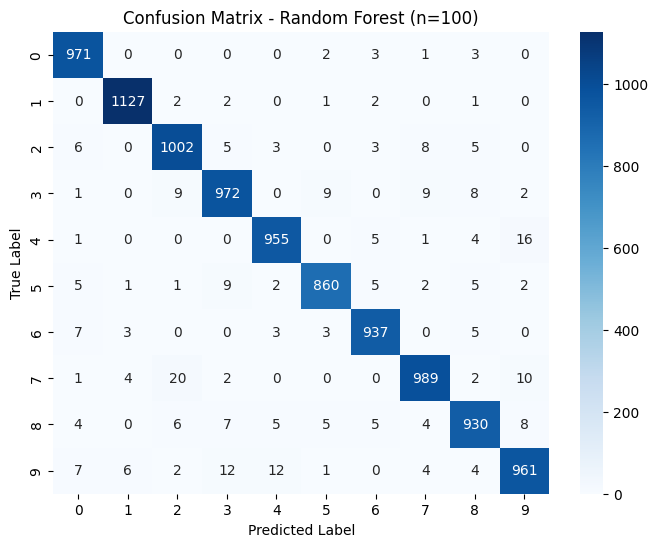


Training MLP (PyTorch with Early Stopping)...
Using device: cpu
Epoch [10/100], Train Loss: 0.0988, Val Loss: 0.1510
Early stopping triggered at epoch 17!
Finished Training. Total time: 159.37s
Loading best model state with val loss: 0.1454

--- Metrics for MLP (30, 20) [PyTorch w/ Early Stop] ---
Accuracy: 0.9629
F1-Score (Weighted): 0.9629


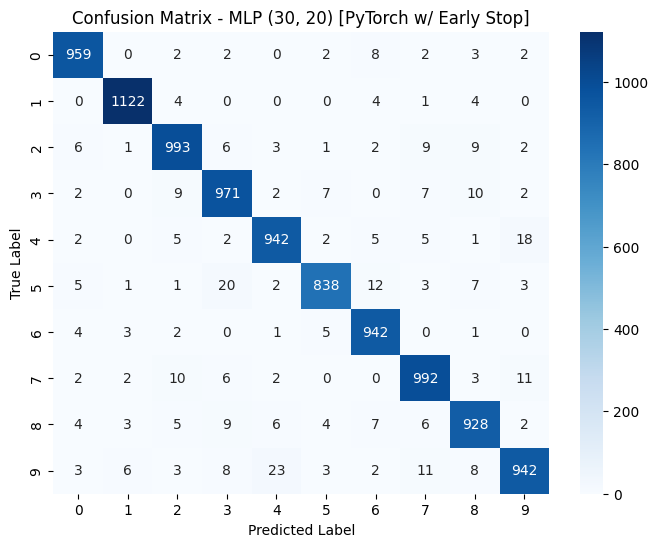

(0.9629, 0.9628550412669938)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import tensorflow.keras as keras # Use tensorflow.keras to load data
import numpy as np
import time
import copy # Needed for saving the best model state

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load MNIST Data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 2. Preprocess Data for MLP/RF/LR (Flatten and Normalize)
# Normalize to [0, 1]
x_train_flat = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test_flat = x_test.reshape(10000, 784).astype('float32') / 255.0

# --- Train Logistic Regression (Faster) ---
print("\nTraining Logistic Regression (Saga, faster tolerance)...") 
start_time_lr = time.time() 

lr_model = LogisticRegression(
    solver='saga',
    max_iter=1000,           # Max iterations (will stop when converged)
    tol=1e-3,                # <-- THE FIX: Stop earlier. (Default is 1e-4)
    random_state=42,
    n_jobs=-1
)

lr_model.fit(x_train_flat, y_train)

print(f"Logistic Regression trained in {(time.time() - start_time_lr):.2f}s")
print(f"Saga stopped after {lr_model.n_iter_[0]} iterations.")

y_pred_lr = lr_model.predict(x_test_flat)
report_metrics(y_test, y_pred_lr, "Logistic Regression (Saga, tol=1e-3)")

# --- Train Random Forest ---
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(x_train_flat, y_train)
y_pred_rf = rf_model.predict(x_test_flat)
report_metrics(y_test, y_pred_rf, "Random Forest (n=100)")


# ===================================================================
# --- Define and Train MLP (PyTorch Implementation) ---
# ===================================================================

# --- 1. Define PyTorch Model using nn.Linear ---
class MLP_PyTorch(nn.Module):
    def __init__(self):
        super(MLP_PyTorch, self).__init__()
        self.layer1 = nn.Linear(784, 30)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(30, 20)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(20, 10)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x_out = self.output_layer(x)
        return x_out

# --- 2. Prepare Data for PyTorch ---
x_train_tensor = torch.tensor(x_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_flat, dtype=torch.float32)

batch_size = 64
full_train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

# --- 3. Initialize Model, Loss, and Optimizer ---
print("\nTraining MLP (PyTorch with Early Stopping)...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pt_model = MLP_PyTorch().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pt_model.parameters())

# --- 4. PyTorch Training Loop with Early Stopping ---
num_epochs = 100
patience = 5
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None

start_time = time.time()

for epoch in range(num_epochs):
    # --- Training Pass ---
    pt_model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = pt_model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)

    # --- Validation Pass ---
    pt_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)
            
            outputs_val = pt_model(inputs_val)
            val_loss = criterion(outputs_val, labels_val)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    
    # --- MODIFIED PRINT: Only print every 10 epochs ---
    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(pt_model.state_dict())
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break # Exit the training loop

print(f"Finished Training. Total time: {(time.time() - start_time):.2f}s")

# --- 5. Evaluate the PyTorch Model ---
if best_model_state:
    print(f"Loading best model state with val loss: {best_val_loss:.4f}")
    pt_model.load_state_dict(best_model_state)
else:
    print("Warning: Early stopping did not find a best model. Using last model state.")

pt_model.eval() 
x_test_tensor_gpu = x_test_tensor.to(device)

with torch.no_grad():
    y_prob_mlp_pt = pt_model(x_test_tensor_gpu)

y_prob_mlp_pt_cpu = y_prob_mlp_pt.cpu().numpy()
y_pred_mlp_pt = np.argmax(y_prob_mlp_pt_cpu, axis=1)

report_metrics(y_test, y_pred_mlp_pt, "MLP (30, 20) [PyTorch w/ Early Stop]")


--- 3.1.2: t-SNE Visualization (Full Test Set) ---
Extracting untrained model features...
Extracting trained model features...
Running t-SNE on untrained features (≈1-2 min)...
Running t-SNE on trained features (≈1-2 min)...


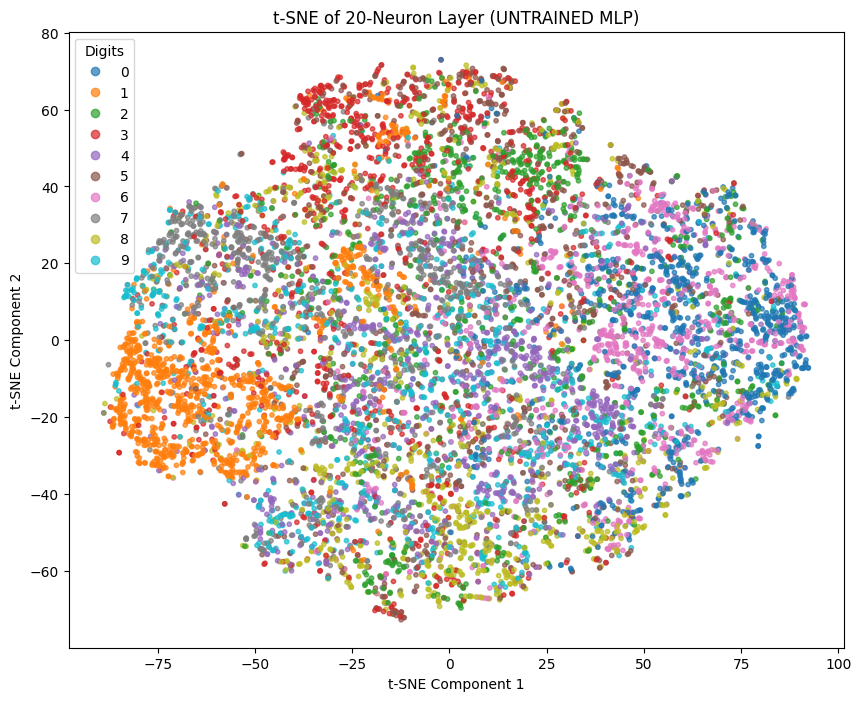

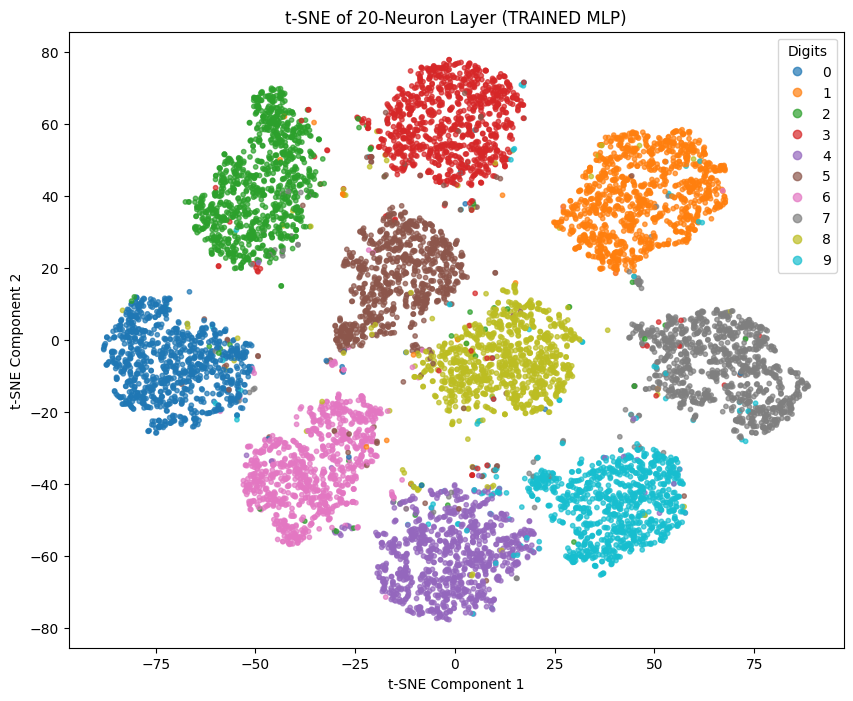

In [ ]:

print("\n--- 3.1.2: t-SNE Visualization (Full Test Set) ---")

# Get features from the UNTRAINED model

untrained_model = MLP_PyTorch().to(device)

def get_layer2_features(model, x_data, device):
    """Extract outputs from the 20-neuron layer (layer2)."""
    model.eval()
    feats = []
    with torch.no_grad():
        x_data = x_data.to(device)
        for i in range(0, len(x_data), 512):   # batch for efficiency
            batch = x_data[i:i+512]
            out1 = model.relu1(model.layer1(batch))
            out2 = model.relu2(model.layer2(out1))   # 20-neuron layer
            feats.append(out2.cpu().numpy())
    return np.concatenate(feats, axis=0)

# Use all 10 000 MNIST test samples
x_sample_tensor = x_test_tensor
y_sample = y_test

print("Extracting untrained model features...")
untrained_features = get_layer2_features(untrained_model, x_sample_tensor, device)


# Get features from the TRAINED model

print("Extracting trained model features...")
trained_features = get_layer2_features(pt_model, x_sample_tensor, device)

# Run t-SNE
print("Running t-SNE on untrained features (≈1-2 min)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_untrained = tsne.fit_transform(untrained_features)

print("Running t-SNE on trained features (≈1-2 min)...")
tsne_trained = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_trained = tsne.fit_transform(trained_features)

# Plot Results
plot_tsne(tsne_untrained, y_sample, "t-SNE of 20-Neuron Layer (UNTRAINED MLP)")
plot_tsne(tsne_trained, y_sample, "t-SNE of 20-Neuron Layer (TRAINED MLP)")



--- 3.1.3: Testing Trained MNIST MLP on Fashion-MNIST (Full Test Set) ---

--- Metrics for Trained MNIST MLP tested on Fashion-MNIST ---
Accuracy: 0.0857
F1-Score (Weighted): 0.0625


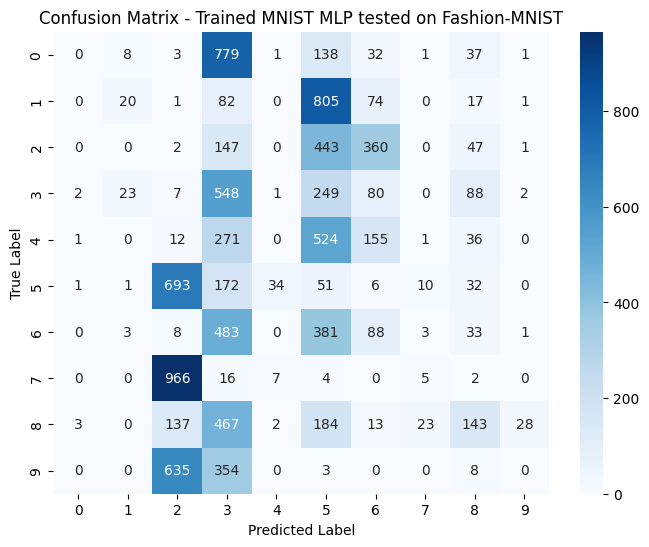

Extracting MNIST and Fashion-MNIST embeddings...
Running t-SNE for MNIST embeddings (≈1-2 min)...
Running t-SNE for Fashion-MNIST embeddings (≈1-2 min)...


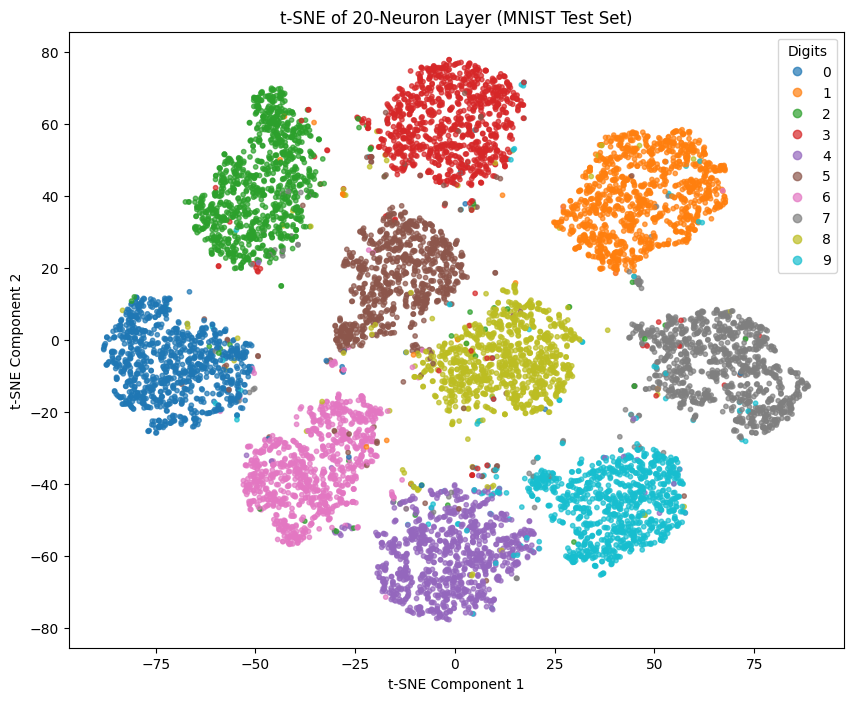

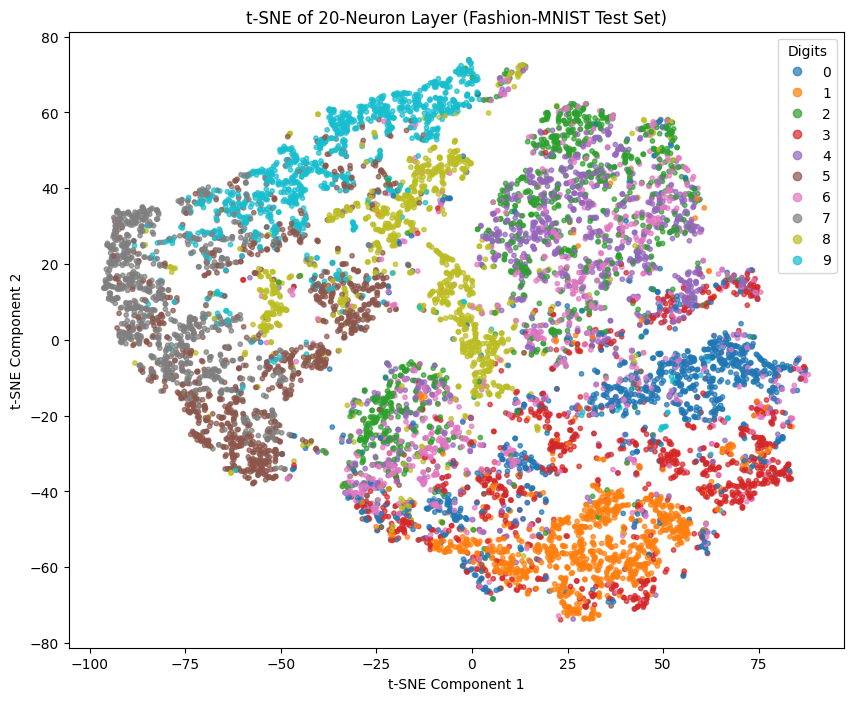

In [ ]:

print("\n--- 3.1.3: Testing Trained MNIST MLP on Fashion-MNIST (Full Test Set) ---")

# Load Fashion-MNIST Dataset
(x_train_fash, y_train_fash), (x_test_fash, y_test_fash) = keras.datasets.fashion_mnist.load_data()

# Normalize and flatten (same as MNIST preprocessing)
x_test_fash_flat = x_test_fash.reshape(10000, 784).astype('float32') / 255.0
x_test_fash_tensor = torch.tensor(x_test_fash_flat, dtype=torch.float32).to(device)
y_test_fash = np.array(y_test_fash)


# Evaluate MNIST-trained model on Fashion-MNIST
pt_model.eval()
with torch.no_grad():
    y_prob_fash = pt_model(x_test_fash_tensor)
y_pred_fash = np.argmax(y_prob_fash.cpu().numpy(), axis=1)

report_metrics(y_test_fash, y_pred_fash, "Trained MNIST MLP tested on Fashion-MNIST")


# Extract 20-Neuron Layer Features (Full Test Sets)
print("Extracting MNIST and Fashion-MNIST embeddings...")
features_mnist = get_layer2_features(pt_model, x_test_tensor, device)
features_fash = get_layer2_features(pt_model, x_test_fash_tensor, device)

# Run t-SNE for Both Datasets
print("Running t-SNE for MNIST embeddings (≈1-2 min)...")
tsne_mnist = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_mnist = tsne_mnist.fit_transform(features_mnist)

print("Running t-SNE for Fashion-MNIST embeddings (≈1-2 min)...")
tsne_fash = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_fash = tsne_fash.fit_transform(features_fash)

# Plot and Compare
plot_tsne(tsne_results_mnist, y_test, "t-SNE of 20-Neuron Layer (MNIST Test Set)")
plot_tsne(tsne_results_fash, y_test_fash, "t-SNE of 20-Neuron Layer (Fashion-MNIST Test Set)")



--- 3.2: CNN Implementation on MNIST (with Early Stopping) ---
Training on device: cpu

Epoch [1/100] - Loss: 0.2492 - Val Acc: 97.07%
Epoch [10/100] - Loss: 0.0086 - Val Acc: 98.63%
Epoch [20/100] - Loss: 0.0052 - Val Acc: 98.75%

Early stopping at epoch 28 (no improvement in 5 epochs)

Training completed in 1901.04s
Best Validation Accuracy: 98.93%

--- Metrics for Simple CNN (32 filters, 128 FC neurons) with Early Stopping ---
Accuracy: 0.9878
F1-Score (Weighted): 0.9878


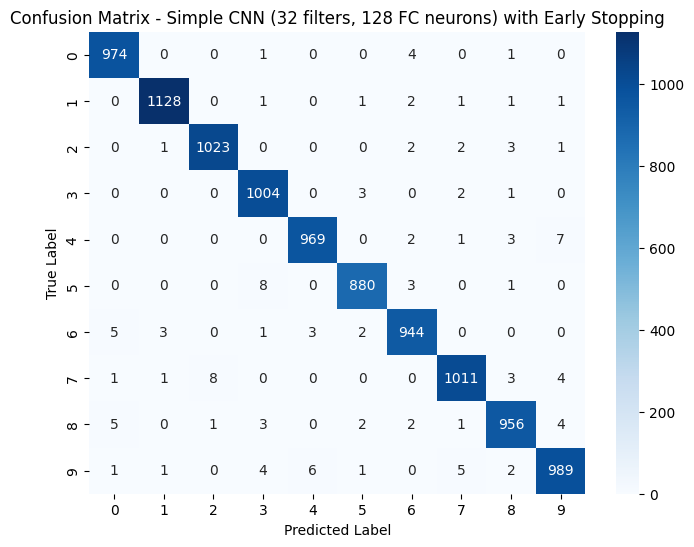

(0.9878, 0.9877974554704824)

In [10]:
print("\n--- 3.2: CNN Implementation on MNIST (with Early Stopping) ---")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np

# Prepare MNIST Data for CNN (reshape to 1x28x28)
x_train_cnn = x_train.reshape(-1, 1, 28, 28).astype('float32') / 255.0
x_test_cnn = x_test.reshape(-1, 1, 28, 28).astype('float32') / 255.0

x_train_tensor_cnn = torch.tensor(x_train_cnn, dtype=torch.float32)
y_train_tensor_cnn = torch.tensor(y_train, dtype=torch.long)
x_test_tensor_cnn = torch.tensor(x_test_cnn, dtype=torch.float32)
y_test_tensor_cnn = torch.tensor(y_test, dtype=torch.long)

train_dataset_cnn = TensorDataset(x_train_tensor_cnn, y_train_tensor_cnn)
test_dataset_cnn = TensorDataset(x_test_tensor_cnn, y_test_tensor_cnn)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=64, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)

# Define the CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training parameters
num_epochs = 100
patience = 5  # for early stopping
best_acc = 0.0
epochs_no_improve = 0
start_time = time.time()

print(f"Training on device: {device}\n")

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0

    for images, labels in train_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_cnn)

    # Evaluate on test data
    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_cnn:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} - Val Acc: {val_acc*100:.2f}%")

    # Early stopping logic
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        best_model_state = cnn_model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
            break

print(f"\nTraining completed in {(time.time() - start_time):.2f}s")
print(f"Best Validation Accuracy: {best_acc*100:.2f}%")

# Load the best model
cnn_model.load_state_dict(best_model_state)

# Final evaluation
cnn_model.eval()
y_pred_list = []

with torch.no_grad():
    for images, _ in test_loader_cnn:
        images = images.to(device)
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)
        y_pred_list.extend(preds.cpu().numpy())

y_pred_cnn = np.array(y_pred_list)
report_metrics(y_test, y_pred_cnn, "Simple CNN (32 filters, 128 FC neurons) with Early Stopping")



--- 3.2.2: Inference using Pretrained CNNs (AlexNet & EfficientNet) ---
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\maitr/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100.0%


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\maitr/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%
100.0%
100.0%
100.0%
100.0%
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8025708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8025708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). G


AlexNet Predictions (first 16 samples): [499, 623, 111, 714, 111, 499, 714, 902, 111, 714, 111, 714, 813, 111, 714, 714]
EfficientNet Predictions (first 16 samples): [409, 530, 772, 633, 530, 783, 111, 600, 491, 111, 111, 111, 530, 683, 772, 111]
True MNIST Labels: [7, 4, 5, 8, 0, 1, 6, 4, 6, 3, 6, 5, 4, 1, 9, 3]


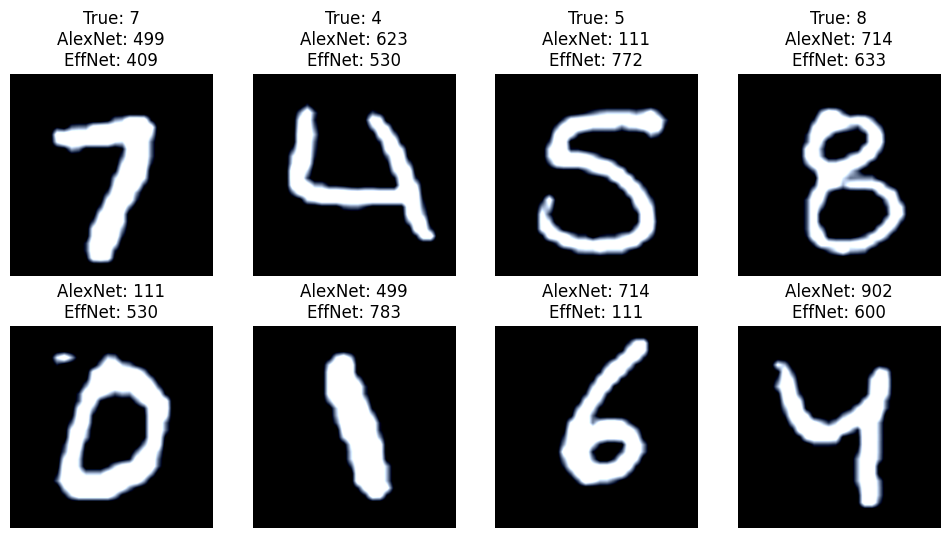

In [12]:
# --- 3.2.2: Using Pretrained CNNs for Inference ---
print("\n--- 3.2.2: Inference using Pretrained CNNs (AlexNet & EfficientNet) ---")

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from PIL import Image

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained models
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).to(device)
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)

alexnet.eval()
efficientnet.eval()

# ImageNet normalization and resizing to 224x224
transform_inference = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # convert MNIST grayscale to 3-channel RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load MNIST test data for inference
mnist_test = MNIST(root="./data", train=False, download=True, transform=transform_inference)
test_loader = DataLoader(mnist_test, batch_size=16, shuffle=True)

# Get a single batch
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Forward pass through both models
with torch.no_grad():
    alexnet_out = alexnet(images)
    efficientnet_out = efficientnet(images)

# Get predicted classes
alexnet_pred = alexnet_out.argmax(dim=1)
efficientnet_pred = efficientnet_out.argmax(dim=1)

print("\nAlexNet Predictions (first 16 samples):", alexnet_pred.tolist())
print("EfficientNet Predictions (first 16 samples):", efficientnet_pred.tolist())
print("True MNIST Labels:", labels.tolist())

# Optional: visualize some predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # unnormalize roughly
    plt.title(f"True: {labels[i].item()}\nAlexNet: {alexnet_pred[i].item()}\nEffNet: {efficientnet_pred[i].item()}")
    plt.axis('off')
plt.show()



--- 3.2.3: Comparing Simple CNN, AlexNet, and EfficientNet-B0 ---

 Simple CNN (Trained on MNIST)
Accuracy: 0.9878
F1-Score: 0.9878
Inference Time: 1.18 s
Model Parameters: 693,962


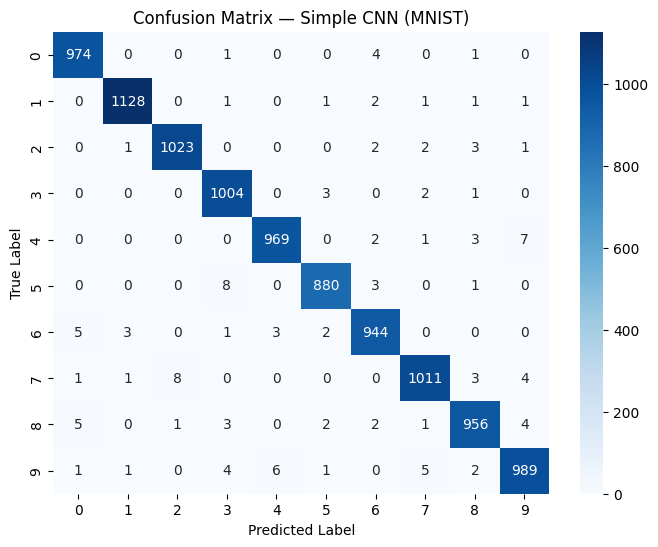


 AlexNet (Pretrained on ImageNet)
Inference Time: 127.56 s
Model Parameters: 61,100,840
Note: Accuracy/F1 not computed since AlexNet not trained on MNIST.

 EfficientNet-B0 (Pretrained on ImageNet)
Inference Time: 120.13 s
Model Parameters: 5,288,548
Note: Accuracy/F1 not computed since EfficientNet not trained on MNIST.

---Model Comparison Summary ---


,Model,Accuracy,F1-Score,Parameters,Inference Time (s)
0,Simple CNN (MNIST-trained),0.9878,0.9878,"693,962",1.18
1,AlexNet (Pretrained),N/A,N/A,"61,100,840",127.56
2,EfficientNet-B0 (Pretrained),N/A,N/A,"5,288,548",120.13


In [13]:
# --- 3.2.3: Model Comparison ---
print("\n--- 3.2.3: Comparing Simple CNN, AlexNet, and EfficientNet-B0 ---")

import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

#  Evaluate Simple CNN (Trained on MNIST)

cnn_model.eval()
start_time = time.time()

y_pred_cnn, y_true_cnn = [], []

with torch.no_grad():
    for images, labels in test_loader_cnn:  # same loader used during training
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)
        y_pred_cnn.extend(preds.cpu().numpy())
        y_true_cnn.extend(labels.cpu().numpy())

cnn_inference_time = time.time() - start_time
cnn_acc = accuracy_score(y_true_cnn, y_pred_cnn)
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average='weighted')
cnn_params = sum(p.numel() for p in cnn_model.parameters())

print(f"\n Simple CNN (Trained on MNIST)")
print(f"Accuracy: {cnn_acc:.4f}")
print(f"F1-Score: {cnn_f1:.4f}")
print(f"Inference Time: {cnn_inference_time:.2f} s")
print(f"Model Parameters: {cnn_params:,}")

# Confusion Matrix
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix — Simple CNN (MNIST)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluate AlexNet (Pretrained on ImageNet)

alexnet.eval()
start_time = time.time()

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = alexnet(images)
        _ = outputs.argmax(dim=1)  # Just to simulate inference
alexnet_inference_time = time.time() - start_time
alexnet_params = sum(p.numel() for p in alexnet.parameters())

print(f"\n AlexNet (Pretrained on ImageNet)")
print(f"Inference Time: {alexnet_inference_time:.2f} s")
print(f"Model Parameters: {alexnet_params:,}")
print("Note: Accuracy/F1 not computed since AlexNet not trained on MNIST.")

# Evaluate EfficientNet-B0 (Pretrained on ImageNet)

efficientnet.eval()
start_time = time.time()

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = efficientnet(images)
        _ = outputs.argmax(dim=1)
efficientnet_inference_time = time.time() - start_time
efficientnet_params = sum(p.numel() for p in efficientnet.parameters())

print(f"\n EfficientNet-B0 (Pretrained on ImageNet)")
print(f"Inference Time: {efficientnet_inference_time:.2f} s")
print(f"Model Parameters: {efficientnet_params:,}")
print("Note: Accuracy/F1 not computed since EfficientNet not trained on MNIST.")

# Summary Table

comparison_df = pd.DataFrame({
    "Model": ["Simple CNN (MNIST-trained)", "AlexNet (Pretrained)", "EfficientNet-B0 (Pretrained)"],
    "Accuracy": [f"{cnn_acc:.4f}", "N/A", "N/A"],
    "F1-Score": [f"{cnn_f1:.4f}", "N/A", "N/A"],
    "Parameters": [
        f"{cnn_params:,}",
        f"{alexnet_params:,}",
        f"{efficientnet_params:,}"
    ],
    "Inference Time (s)": [
        f"{cnn_inference_time:.2f}",
        f"{alexnet_inference_time:.2f}",
        f"{efficientnet_inference_time:.2f}"
    ]
})

print("\n---Model Comparison Summary ---")
display(comparison_df)
